In [1]:
import os
import sys

import numpy as np
import copy

from glob import glob
import argparse

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
base_dict = {
    'name':'',
    'file': '',
    'BRAM_18K': -1,
    'DSP48E': -1,
    'FF': -1,
    'LUT': -1,
    'URAM':-1,
    'LAT_min':-1,
    'LAT_max': -1,
    'INT_min': -1,
    'INT_max': -1,
    'ap_tot': -1,
    'ap_frac': -1,
    'ap_int': -1,
    'ap_quant': '',
    'ap_over': '',
    'strategy': '',
    'reuse': -1,
    'keras_auc': -1,
    'hls_auc': -1,
    'rel_auc': -1,
    'model': '',
    'static': 1,
    'mac_max': -1,
    'mac_min': -1,
    'npar': -1,
    'keras_mse_x': -1,
    'hls_mse_x': -1,
    'keras_mse_a': -1,
    'hls_mse_a': -1,
    'rel_mse_x': -1,
    'rel_mse_a': -1
}

In [4]:
fpga = {}
fpga['DSP48E'] = 5520
fpga['BRAM_18K'] = 4320
fpga['FF'] = 1326720
fpga['LUT'] = 663360

In [5]:
label='ThesePlots'

In [6]:
models = []

In [7]:
models.append(
{
'name': "1033p",
'dir': "MyTCN_10,3,1:10,3,1_30_CBNormTrue_DBNormFalse_ll1_ptype2_penXTrue_penATrue_bkgPenTrue_regBiasTrue_AvgPool",
'intbit': 10,
'lstyle': 'o-',
'fstyle': 'full',
})

models.append(
{
'name': "14783p",
'dir': "MyTCN_20,3,1:20,3,1_40_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenTrue_regBiasTrue_Flatten",
'intbit': 12,
'lstyle': 'o--',
'fstyle': 'none',
})

In [8]:
fld = "/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hls/"

In [9]:
for imod,mod in enumerate(models):
    print(mod['name'])
    
    tfiles = glob(f"{fld}/{mod['dir']}/reports/*.txt")
    
    these_dicts = []
    
    for ff in tfiles:
        with open(ff, 'r') as hf:
            
            this_dict = copy.deepcopy(base_dict)
            this_dict['name'] = ff.split('/')[-1].replace('.txt', '')
            this_dict['file'] = ff

            this_dict['reuse'] = int(this_dict['name'].split('_reuse_')[-1].split('_')[0])
            this_dict['strategy'] = this_dict['name'].split('_reuse_')[-1].split('_')[1]

            modes = this_dict['name'].split('_reuse_')[0].replace('model_', '').split('.')

            if 'NonStatic' in ff: this_dict['static'] = 0

            this_dict['ap_tot'] = int(modes[0])
            this_dict['ap_int'] = int(modes[1])
            this_dict['ap_frac'] = this_dict['ap_tot'] - this_dict['ap_int']
            this_dict['ap_quant'] = 'std' if len(modes) < 3 else modes[2]
            this_dict['ap_over'] = 'std' if len(modes) < 3 else modes[3]
            if 'tcn' in ff.lower():
                this_dict['model'] = 'tcn'
            elif 'gru' in ff.lower():
                this_dict['model'] = 'gru'
            elif 'lstm' in ff.lower():
                this_dict['model'] = 'lstm'

            # this_dict['npar'] = n_params_gru if 'GRU' in ff or 'gru' in ff else n_params_lstm

            for line in hf:
                if 'function' in line or 'none' in line or 'dataflow' in line:
                    if '_' in line: continue

                    sline = line.split()
                    sline = [ sl.replace('|', '') for sl in sline ]

                    this_dict['LAT_min'] = float(sline[3])
                    this_dict['LAT_max'] = float(sline[6])

                    this_dict['INT_min'] = float(sline[9])
                    this_dict['INT_max'] = float(sline[10])

                    this_dict['mac_max'] = float(this_dict['npar'])/float(this_dict['INT_max'])
                    this_dict['mac_min'] = float(this_dict['npar'])/float(this_dict['INT_min'])

                    # if sline[4] != sline[7]:
                    #     print(sline[4], sline[7])
                    #     break

                    if 'ms' in sline[4]:
                        this_dict['LAT_min'] = this_dict['LAT_min']*1e3
                    if 'ns' in sline[4]:
                        this_dict['LAT_min'] = this_dict['LAT_min']*1e-3

                    if 'ms' in sline[7]:
                        this_dict['LAT_max'] = this_dict['LAT_max']*1e3
                    if 'ns' in sline[7]:
                        this_dict['LAT_max'] = this_dict['LAT_max']*1e-3

                    # if 'none' in lat_unit:
                    #     lat_unit = sline[4]
                    # else:
                    #     assert sline[4] == lat_unit

                if 'Total' in line and this_dict['FF'] == -1:
                    sline = line.split()
                    sline = [ sl.replace('|', '') for sl in sline ]

                    this_dict['BRAM_18K']  = int( sline[2] )
                    this_dict['DSP48E']    = int( sline[3] )
                    this_dict['FF']        = int( sline[4] )
                    this_dict['LUT']       = int( sline[5] )
                    this_dict['URAM']      = int( sline[6] )

                if 'KERAS_AUC' in line:
                    sline = line.split()
                    this_dict['keras_auc'] = float(sline[1])

                if 'HLS_AUC' in line:
                    sline = line.split()
                    this_dict['hls_auc'] = float(sline[1])
                
                if 'KERAS_MSE_X' in line:
                    sline = line.split()
                    this_dict['keras_mse_x'] = float(sline[1])
                    
                if 'HLS_MSE_X' in line:
                    sline = line.split()
                    this_dict['hls_mse_x'] = float(sline[1])
                    
                if 'KERAS_MSE_A' in line:
                    sline = line.split()
                    this_dict['keras_mse_a'] = float(sline[1])
                    
                if 'HLS_MSE_A' in line:
                    sline = line.split()
                    this_dict['hls_mse_a'] = float(sline[1])

            this_dict['rel_auc'] = abs( this_dict['hls_auc'] ) / this_dict['keras_auc']
            this_dict['rel_mse_x'] = abs( this_dict['keras_mse_x'] ) / this_dict['hls_mse_x']
            this_dict['rel_mse_a'] = abs( this_dict['keras_mse_a'] ) / this_dict['hls_mse_a']
            these_dicts.append(this_dict)

    tdict = copy.deepcopy(base_dict)
    for kk in tdict:
        tdict[kk] = [ dd[kk] for dd in these_dicts]
    
    mod['pd'] = pd.DataFrame.from_dict(tdict)
    print(mod['pd'].head())

1033p
                                            name  \
0   model_28.8_reuse_50_Resource_Static_BigTable   
1    model_10.8_reuse_1_Resource_Static_BigTable   
2     model_26.8_reuse_5_Latency_Static_BigTable   
3   model_22.10_reuse_5_Resource_Static_BigTable   
4  model_18.12_reuse_50_Resource_Static_BigTable   

                                                file  BRAM_18K  DSP48E     FF  \
0  /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...        16      84  14755   
1  /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...       104       0   8153   
2  /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...         0     335  22034   
3  /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...       128     432  16230   
4  /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/hl...        11      20   9140   

     LUT  URAM  LAT_min  LAT_max  INT_min  ...  static   mac_max   mac_min  \
0  20902     0   10.210   11.400   1153.0  ...       1 -0.000441 -0.000867   
1  46577     0    5.805    6.165   115

In [10]:
plot_loc = f'model_plots/{label}'

if not os.path.exists(plot_loc):
    os.makedirs(plot_loc)

In [11]:
def get_plot(pd_dict, st, reu, apint, var, max_x = 30, stat=1):
    xi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.static == stat) ].ap_frac.to_numpy()
    yi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.static == stat) ][var].to_numpy()
    sort_i = xi.argsort()
    x = np.array(xi[sort_i], dtype=int)
    y = yi[sort_i]
    y = y[x < max_x+1]
    x = x[x < max_x+1]
    return [x,y]

In [12]:
def get_plot_tot(pd_dict, st, reu, apint, var, model, max_x = 30, stat=1):
    xi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.static == stat) ].ap_tot.to_numpy()
    yi = pd_dict[ (pd_dict.strategy == st) & (pd_dict.reuse==reu) & (pd_dict.ap_int == apint) & (pd_dict.static == stat) ][var].to_numpy()
    sort_i = xi.argsort()
    x = np.array(xi[sort_i], dtype=int)
    y = yi[sort_i]
    y = y[x < max_x+1]
    x = x[x < max_x+1]
    return [x,y]

[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.50001178, 0.56884676, 0.73696021, 0.66433086, 0.65151481,
       0.64948325, 0.64905274, 0.64826537, 0.64806768, 0.64802336])]
[array([ 6,  8, 10, 12, 14, 16, 18, 20]), array([0.52351468, 0.54965715, 0.58937841, 0.60799348, 0.61189316,
       0.61283929, 0.61283809, 0.61255883])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.50001178, 0.80553725, 0.99900968, 0.99931745, 0.99941116,
       0.99943044, 0.99944762, 0.9994521 , 0.9994531 , 0.99945306])]
[array([ 4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.51795593, 0.81666066, 0.71526171, 0.87717213, 0.90020656,
       0.90347197, 0.90422939, 0.90434276, 0.90438868])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.50001178, 0.80413971, 0.9996184 , 0.9999846 , 1.00000004,
       1.00000028, 1.00000008, 1.00000004, 1.00000004, 1.        ])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.51254379, 0.51798043, 0.81466083, 0.95066866, 0.99937094,
 

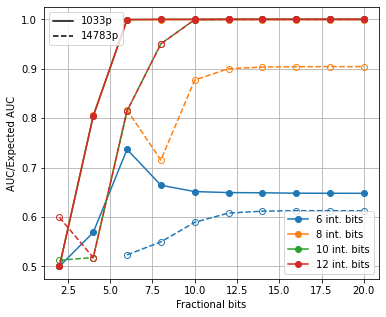

[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.00669957, 0.0064278 , 0.00290923, 0.00130513, 0.00118267,
       0.00114943, 0.0011398 , 0.0011365 , 0.00113497, 0.001135  ])]
[array([ 6,  8, 10, 12, 14, 16, 18, 20]), array([0.00439017, 0.00404389, 0.00347361, 0.00319853, 0.00309342,
       0.00306972, 0.00306606, 0.00306438])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.00669957, 0.01118447, 0.07985671, 0.54368722, 0.83073084,
       0.81693771, 0.79049745, 0.77946852, 0.77789795, 0.77759896])]
[array([ 4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.00430201, 0.00443743, 0.00450683, 0.01240175, 0.01777455,
       0.01864202, 0.01872094, 0.01873134, 0.01873627])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.00669957, 0.01118553, 0.08042419, 0.59853365, 1.03954846,
       1.04558575, 1.01556102, 1.00222653, 1.00052163, 1.00022881])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([3.07511143e-07, 4.26040968e-03, 4.43964889e-03, 4.65849275e-0

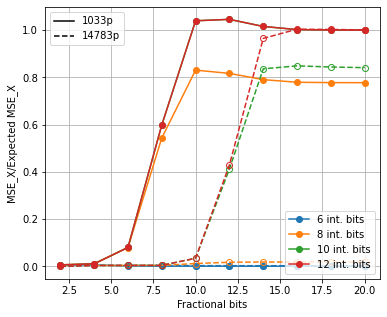

[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.00514637, 0.00607051, 0.0044228 , 0.00401386, 0.0038991 ,
       0.00389181, 0.00388588, 0.00388421, 0.00388704, 0.00388746])]
[array([ 6,  8, 10, 12, 14, 16, 18, 20]), array([0.0050545 , 0.0050645 , 0.00512436, 0.00508083, 0.00504717,
       0.00504005, 0.00503859, 0.00503818])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.00514637, 0.01188096, 0.06545015, 0.18752837, 0.20259925,
       0.20376643, 0.20348499, 0.20333409, 0.20335099, 0.20334592])]
[array([ 4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.00509145, 0.00510676, 0.00548088, 0.01408827, 0.01809386,
       0.01873731, 0.01883528, 0.01886603, 0.01887484])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([0.00514637, 0.01194847, 0.08185373, 0.60407371, 0.93031856,
       0.99047289, 0.99823136, 0.99954817, 0.99988536, 0.99997388])]
[array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), array([1.08145039e-06, 5.08291917e-03, 5.10976521e-03, 5.76040358e-0

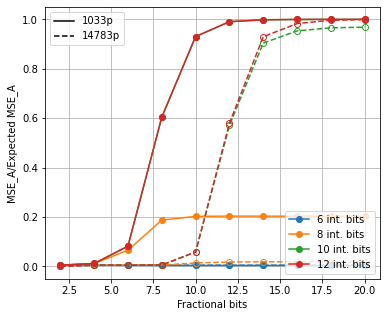

In [13]:
strat = 'Resource'

vars = ['rel_auc', 'rel_mse_x', 'rel_mse_a']
var_labs = [ r'AUC/Expected AUC', 'MSE_X/Expected MSE_X', 'MSE_A/Expected MSE_A']
reuse_to_plot=1

marker=['o', 'v', 's', '*', 'D', '^', 'P']

max_x = 22

for reuse in [reuse_to_plot]:
    
    for ivv,vv in enumerate(vars):
        

        fig, ax = plt.subplots(1,1,figsize=(6,5))
        
        lines = []
        llabels = []
        for iib,ib in enumerate([6, 8, 10, 12]):
            for imod,mod in enumerate(models):
                tleg = f'{ib} int. bits' if imod==0 else None
                myplot = get_plot(mod['pd'], strat, reuse, ib, vv, max_x)
                print(myplot)
                ax.plot( myplot[0],myplot[1], mod['lstyle'], color=f'C{iib}', 
                        label=tleg, fillstyle=mod['fstyle'] )                
                
                if iib==0:
                    lines.append( mpl.lines.Line2D([0], [0], ls=mod['lstyle'][1:], color='black') )
                    llabels.append( mod['name'] )
        
        
        # plt.legend(title=f'Strat.: {strat},\n Reuse: {reuse}', frameon=False)
        ax.legend(frameon=True, loc='lower right')
        # plt.legend(frameon=False)
        ax.set_xlabel('Fractional bits')
        if 'LAT' in vv:
            ax.set_ylabel(var_labs[ivv]+f' (us)')
        else:
            ax.set_ylabel(var_labs[ivv])
        
        leg = mpl.legend.Legend(ax, lines, labels=llabels,
            loc='upper left', frameon=True)
        ax.add_artist(leg)

        # plt.ylim(0,1.1)
        # plt.title(model_name, loc='left', fontweight="bold")
        plt.grid()
        plt.savefig(f"{plot_loc}/{vv}_{reuse}.pdf")
        plt.show()

In [14]:
reuses = [1, 5, 10, 50, 100]
# reuses = [1, 5, 10, 50, 100]
reuses_labels = reuses

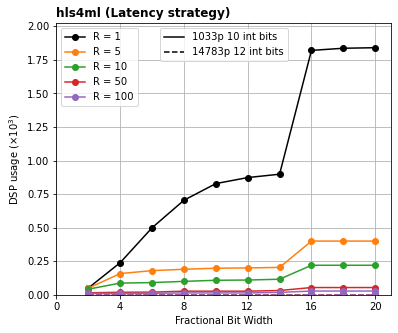

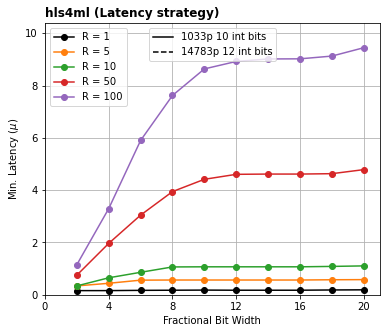

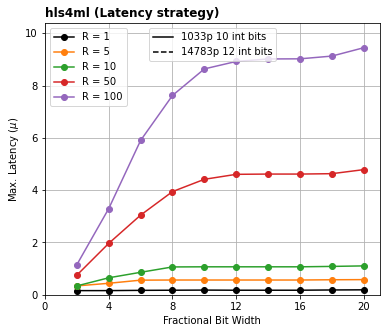

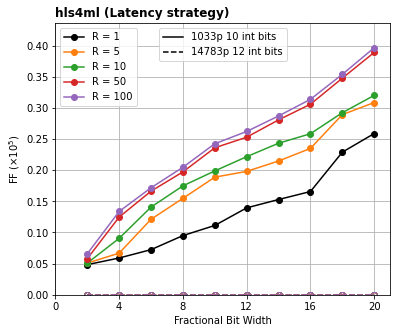

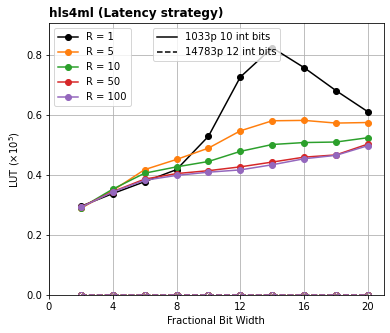

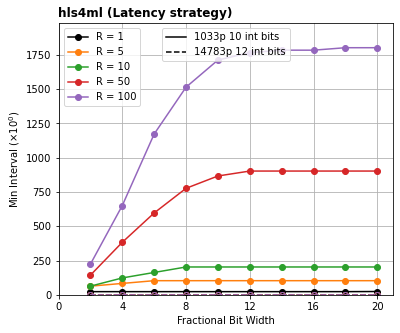

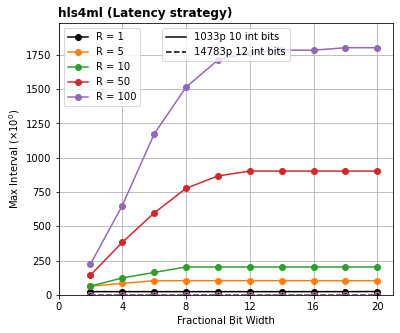

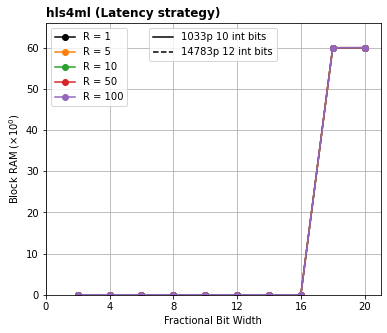

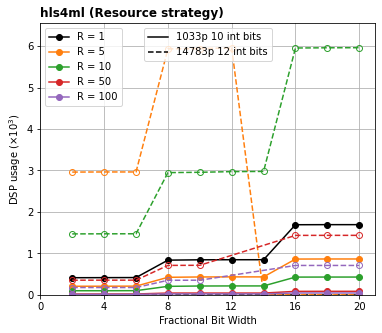

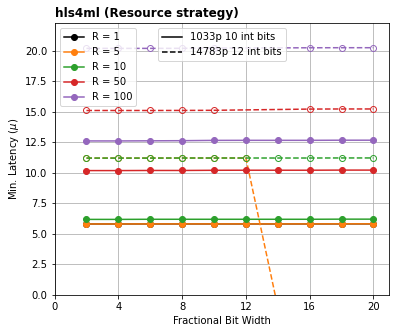

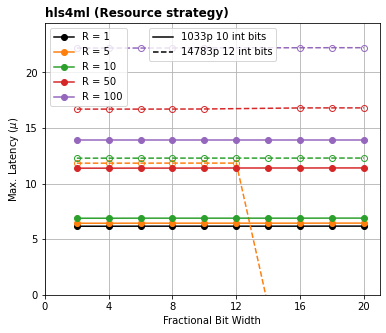

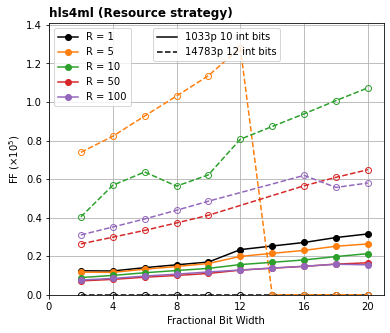

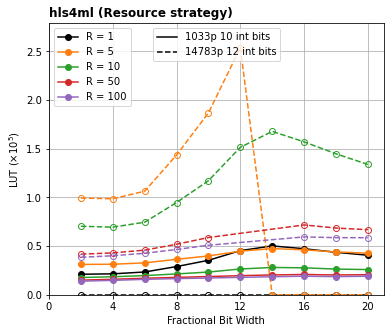

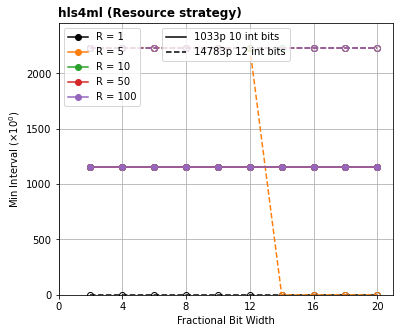

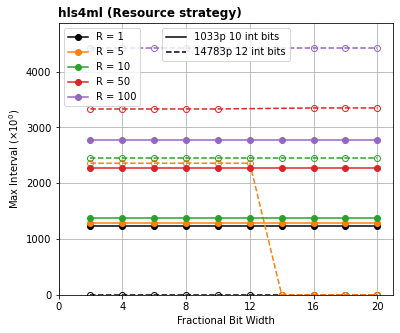

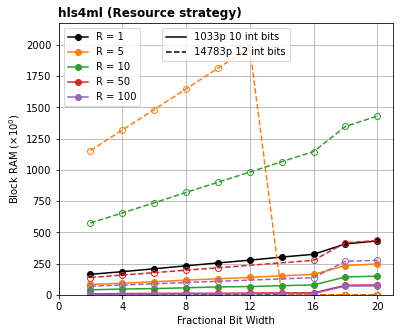

In [15]:
vars = ['DSP48E', f'LAT_min', f'LAT_max', 'FF', 'LUT', 'INT_min', 'INT_max', 'BRAM_18K']
var_labs = ['DSP usage', f'Min. Latency', f'Max. Latency', 'FF', 'LUT', 
            'Min Interval', 'Max Interval', 'Block RAM']
facts = [3, 0, 0, 5, 5, 0, 0, 0, 0, 3]

maxx = 20
    
for strat in ['Latency', 'Resource']:
    
    for ivv,vv in enumerate(vars):

        fig, ax = plt.subplots(1,1,figsize=(6,5))
        # plt.xlim(9,31)

        # for ire,reuse in enumerate([50, 100, 200, 500, 1000, 2000]):
        # for ire,reuse in enumerate([50, 100, 200, 1000]):
        pmax = 0
        pmin = 0
        
        lines = []
        llabels = []
        
        for ire,reuse in enumerate(reuses):

            col=f'C{ire}'
            if reuse == 1:
                col = 'black'

                
            for imod,mod in enumerate(models):
                tleg = f'R = {reuse}' if imod==0 else None
                myplot = get_plot(mod['pd'], strat, reuse, ib, vv, max_x)
                ax.plot( myplot[0],myplot[1]/(10**facts[ivv]), mod['lstyle'], color=col, 
                        label=tleg, fillstyle=mod['fstyle'] )                
                
                if ire==0:
                    lines.append( mpl.lines.Line2D([0], [0], ls=mod['lstyle'][1:], color='black') )
                    llabels.append( mod['name'] + ' ' + str(mod['intbit']) + ' int bits'  )
                
                if len(myplot[1][myplot[1]>0]) < 1: continue
                
                if max(myplot[1][myplot[1]>0]/(10**facts[ivv])) > pmax:
                    pmax = max(myplot[1][myplot[1]>0]/(10**facts[ivv]))
                if min(myplot[1][myplot[1]>0]/(10**facts[ivv])) < pmin:
                    pmin = min(myplot[1][myplot[1]>0]/(10**facts[ivv]))


        ax.set_xticks(np.arange(0, maxx+1, 4.0))
        ax.set_xlim(0,maxx+1)
        ax.set_ylim(pmin, pmax*1.1)

        # ax.legend(title=f'{INTBIT} int. bits'+'\n'+f'Dense R = {dense_reuse}', frameon=True,
        #           loc='upper left')
        ax.legend(frameon=True,
                  loc='upper left')
        # plt.legend(frameon=False)
        ax.set_xlabel('Fractional Bit Width')
        if 'LAT' in vv:
            # ax.set_yscale('log')
            # unit = lat_unit.replace('u', '$\\mu$')
            ax.set_ylabel(var_labs[ivv] +f' ($\\mu$)')
        else:
            ax.set_ylabel(var_labs[ivv] +f' ($\\times 10^{str(facts[ivv])} $)')

        leg = mpl.legend.Legend(ax, lines, labels=llabels,
                loc='upper center', frameon=True)
                # bbox_to_anchor=(0.55, 1.), frameon=True)
        ax.add_artist(leg)

        # if vv in fpga:
        #     ax.plot([0,21], [fpga[vv]/(10**facts[ivv]), fpga[vv]/(10**facts[ivv])], '--', color='gray') 

        plt.title(f'hls4ml ({strat} strategy)', loc='left', fontweight="bold")
        plt.grid()
        plt.savefig(f"{plot_loc}/{vv}_{strat}.pdf", bbox_inches='tight')
        plt.show()